connecting to google drive


In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


specifying directory


In [2]:
%ls
%cd drive/MyDrive/NLU/models
%ls

drive/  sample_data/
/content/drive/MyDrive/NLU/models
 clean_classifier.pth
'embedd_dirty_data(movie_review).pkl'
 embedd_dirty_data.pkl
 model_for_subjectivity_only_10epochs_ne.pth
 model_for_subjectivity_only_5epochs_dropouts.pth
 new_model_dirt_data_trained.pth
 new_model_subjectivity_data_trained.pth
 new_model_subjectivity_data_trained_.pth


# **Defining the classification network**

In [3]:
!pip install sentence-transformers
import nltk
import torch
import numpy
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from nltk.corpus import movie_reviews
from nltk.corpus import subjectivity
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('subjectivity')
nltk.download('movie_reviews')
nltk.download('punkt')


class pol_database(Dataset):
    def __init__(self,embeddings,labels):
        self.embeddings = embeddings
        #self.stored_sentences = stored_sentences
        self.labels = labels
    def __len__(self):
        return len(self.embeddings)
    def __getitem__(self,id_elem):
        return (self.embeddings[id_elem],self.labels[id_elem])

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(768, 768*2)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(768*3, 384*2)
        self.fc3 = nn.Linear(384*2, 2)
        self.fc4 = nn.Linear(768*2,768*3)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc4(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        output = F.log_softmax(x,dim=1) 
        return output


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 115.0 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=4e1e881773687289bd1ca413379a48384e539f4abea6b518a8bce31d0d6ffe89
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package subjectivity to /root/nltk_data...
[nltk_data]   Unzipping corpora/subjectivity.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **Retrieving the dataset**

In [4]:
def clean(word):
    punctuation_to_remove = {'.', ',', ';', ':', "'", '"', '*', '#', '!', '?', '-', '--', '_', '/', '(', ')', '[', ']', '{', '}','``'}

    if word not in punctuation_to_remove:
        return word
    
def remove_punkt(text):
  tokens_ = []
  for i in range(0,len(text)):

      tokens = nltk.word_tokenize(text[i])
      tokens = [clean(t) for t in tokens]
      tokens = [i for i in tokens if i is not None]
      tokens_.append(tokens)

  return tokens_



def lol2str(doc):
    # flatten & join
    return " ".join([w for sent in doc for w in sent])
def lol2str_(doc):
    # flatten & join
    return " ".join([w for w in doc])
def embedd_review(reviews,model):
    reviews_ebd = []
    for elem in tqdm(reviews):
        a = model.encode(elem,convert_to_numpy=False,convert_to_tensor=True)
        reviews_ebd.append(a)
    with open('embedd_dirty_data(movie_review).pkl', "wb") as fOut:
        pickle.dump({'embedded_review': reviews_ebd}, fOut, protocol=pickle.HIGHEST_PROTOCOL)
    return reviews_ebd

model = SentenceTransformer('all-mpnet-base-v2')

#model_short = SentenceTransformer('all-MiniLM-L12-v2')

model.max_seq_length = 500
mr = movie_reviews
neg = mr.paras(categories='neg')
pos = mr.paras(categories='pos')

obj = subjectivity.sents(categories='obj') 
subj = subjectivity.sents(categories='subj')

corpus_polarity = [lol2str(d) for d in neg] + [lol2str(d) for d in pos]
corpus_subjectivity = [lol2str_(d) for d in obj] + [lol2str_(d) for d in subj]


# **Computing Statistics**


used_sent:  1583820
Number of positive reviews: 1000
Number of negative reviews: 1000
Number of total words in positive reviews: 832564
Number of total words in negative reviews: 751256
Number of total words in both positive and negative reviews: 1583820
Number of average words per review : 792

10 most frequent words in positive reviews:
[(',', 42448), ('the', 41471), ('.', 33714), ('a', 20196), ('and', 19896), ('of', 18636), ('to', 16517), ("'", 15268), ('is', 14059), ('in', 11725)]

10 most frequent words in negative reviews:
[(',', 35269), ('the', 35058), ('.', 32162), ('a', 17910), ('and', 15680), ('of', 15487), ('to', 15420), ("'", 15317), ('is', 11136), ('in', 10097)]


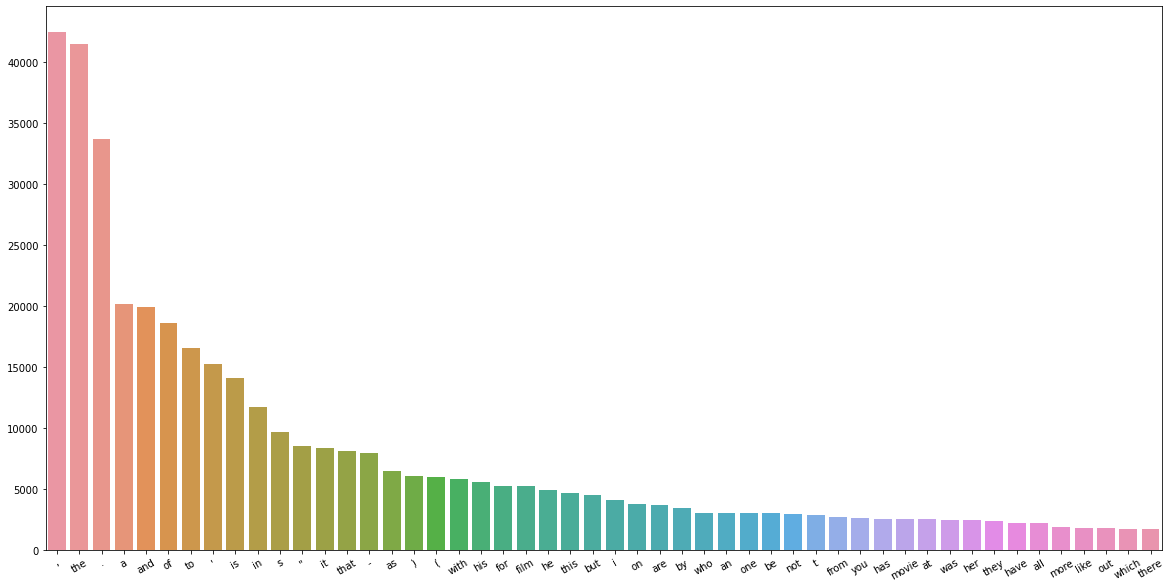

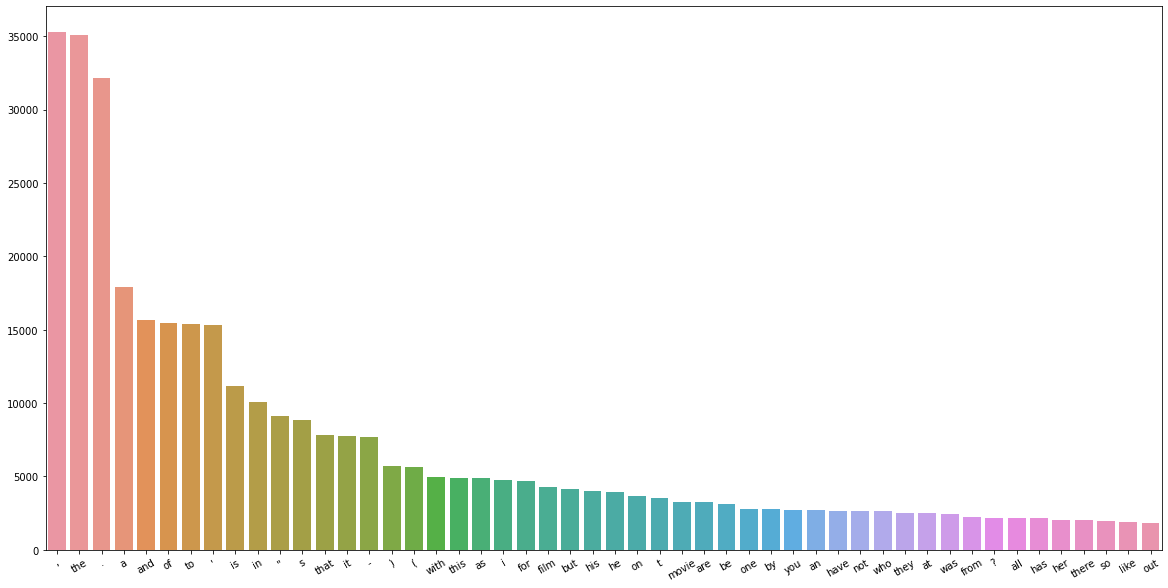

In [5]:
reviews = [list(movie_reviews.words(fileid)) for fileid in movie_reviews.fileids()]

pos_reviews = [review for i, review in enumerate(reviews) if movie_reviews.categories(movie_reviews.fileids()[i])[0] == 'pos']
neg_reviews = [review for i, review in enumerate(reviews) if movie_reviews.categories(movie_reviews.fileids()[i])[0] == 'neg']
pos_review_words = [word.lower() for review in pos_reviews for word in review]
neg_review_words = [word.lower() for review in neg_reviews for word in review]

num_pos_reviews = len(pos_reviews)
num_neg_reviews = len(neg_reviews)
tot_review = pos_reviews + neg_reviews
total_num_words = len(pos_review_words) + len(neg_review_words)
tot_num_review = len(pos_reviews) + len(neg_reviews)
num_pos_words = len(pos_review_words)
num_neg_words = len(neg_review_words)

used_sents = [sent for i in range(tot_num_review) for sent in tot_review[i]]
total_number_sentences = len(used_sents)
print("\nused_sent: ",total_number_sentences)

average_words_per_review = round(total_num_words / len(reviews))

print(f"Number of positive reviews: {num_pos_reviews}")
print(f"Number of negative reviews: {num_neg_reviews}")
print(f"Number of total words in positive reviews: {num_pos_words}")
print(f"Number of total words in negative reviews: {num_neg_words}")
print(f"Number of total words in both positive and negative reviews: {total_num_words}")
print(f"Number of average words per review : {average_words_per_review}")


pos_word_freq = nltk.FreqDist(pos_review_words)
neg_word_freq = nltk.FreqDist(neg_review_words)

print("\n10 most frequent words in positive reviews:")
print(pos_word_freq.most_common(10))
print("\n10 most frequent words in negative reviews:")
print(neg_word_freq.most_common(10))
import pandas as pd
import seaborn as sns
pos_fdist = pos_word_freq.most_common(50)
neg_fdist = neg_word_freq.most_common(50)

## Conversion to Pandas series via Python Dictionary for easier plotting
pos_fdist = pd.Series(dict(pos_fdist))

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(20,10))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=pos_fdist.index, y=pos_fdist.values, ax=ax)
plt.xticks(rotation=30);

neg_fdist = pd.Series(dict(neg_fdist))
fig, ax = plt.subplots(figsize=(20,10))
all_plot = sns.barplot(x=neg_fdist.index, y=neg_fdist.values, ax=ax)
plt.xticks(rotation=30);






# **Preprocessing as punctuation removing**






In [6]:
def clean(word):
    punctuation_to_remove = {'.', ',', ';', ':', "'", '"', '*', '#', '!', '?', '-', '--', '_', '/', '(', ')', '[', ']', '{', '}','``'}

    if word not in punctuation_to_remove:
        return word
    
def remove_punkt(text):
  tokens_ = []
  for i in range(0,len(text)):

      tokens = nltk.word_tokenize(text[i])
      tokens = [clean(t) for t in tokens]
      tokens = [i for i in tokens if i is not None]
      tokens_.append(tokens)

  return tokens_



preprocessing the data, removing punctuation

In [7]:
#comment to train without preprocessing 
corpus_polarity = remove_punkt(corpus_polarity)
corpus_polarity = [lol2str_(i) for i in corpus_polarity]


In [8]:
print(len(corpus_polarity))
print(corpus_polarity[1])
print(len(corpus_subjectivity))
print(corpus_subjectivity[1])

2000
the happy bastard s quick movie review damn that y2k bug it s got a head start in this movie starring jamie lee curtis and another baldwin brother william this time in a story regarding a crew of a tugboat that comes across a deserted russian tech ship that has a strangeness to it when they kick the power back on little do they know the power within going for the gore and bringing on a few action sequences here and there virus still feels very empty like a movie going for all flash and no substance we don t know why the crew was really out in the middle of nowhere we don t know the origin of what took over the ship just that a big pink flashy thing hit the mir and of course we don t know why donald sutherland is stumbling around drunkenly throughout here it s just hey let s chase these people around with some robots the acting is below average even from the likes of curtis you re more likely to get a kick out of her work in halloween h20 sutherland is wasted and baldwin well he s 

Create embedding using transformers library

In [9]:
stored_embeddings = embedd_review(corpus_polarity,model)

100%|██████████| 2000/2000 [01:23<00:00, 23.81it/s]


# **Training Baseline Classifier**

here we train the baseline classifier on the non-processed data.

In [10]:
net = Net()
labels_polarity = numpy.array([0] * 1000 + [1] * 1000) 
X_train, X_test, y_train, y_test = train_test_split(stored_embeddings, labels_polarity, test_size=0.33, random_state=42)
dataset = pol_database(X_train,y_train)
test_dataset = pol_database(X_test,y_test)
train_dataloader = DataLoader(dataset, shuffle=True, batch_size=5)
test_dataloader = DataLoader(test_dataset,shuffle=True, batch_size=5)

In [11]:

device = torch.device("cuda:0")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

def train_model(model_,n_epochs,criterion,train_datal,test_datal,PATH,optimizer_):
  loss_values = []

  for epoch in range(0,n_epochs):  # loop over the dataset multiple times
    j = 0
    model_.to(device)
    running_loss = 0.0
    
    for i, data in (train_datal):
        torch.Tensor(data)
        torch.Tensor(i)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = i.to(device), data.to(device)
        # zero the parameter gradients
        optimizer_.zero_grad()

        #forward + backward + optimize
        outputs = model_(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer_.step()

        loss_values.append(loss.item())
    j+=1
        
  plt.plot(loss_values)
  plt.show()
  torch.save(model_.state_dict(), PATH)
  return loss_values



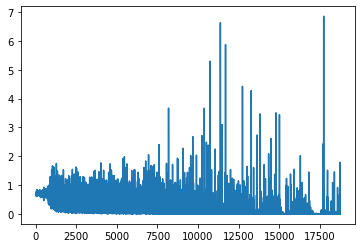

In [12]:
loss_ = train_model(net,70,criterion,train_dataloader,test_dataloader,"new_model_dirt_data_trained.pth",optimizer)


In [13]:
def evalu(test_dataloader_,test_dataset,classifier):
  correct, total = 0, 0
  count_pos, count_neg = 0, 0
  with torch.no_grad():
    for i,data in test_dataloader_:
      torch.Tensor(data)
      torch.Tensor(i)
      
      inputs, labels = i.to(device),data.to(device)
      # calculate output by running through the network
      outputs = classifier(inputs)
      # get the predictions
      __, predicted = torch.max(outputs.data, 1)
      # print("\nOUTPUT : ",outputs)
      # print("\nAAAAAAAAAAAAAAA\n\n")
      # print("\n__ = ",__,"predicted = ",predicted )
      # print("\nlabel : ",labels)
      # update results
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      c = 0
      for i in labels:
        if i == 0 and i==predicted[c]:
          count_neg += 1
        if i == 1 and i==predicted[c]:
          count_pos += 1
        c+=1
    count_neg = (len(test_dataset)/2)-count_neg
    count_pos = (len(test_dataset)/2)-count_pos
    print("count_pos : ",count_pos, "count_neg : ",count_neg)
 
      
  print("correct: ",correct)
  print(f'Accuracy of the network on the {len(test_dataset)} test data: {100 * correct // total} %')
  print(f'Accuracy of the network on the {len(test_dataset)} test data: {100 * correct // total} %')

  print(f'negative mis')

evalu(test_dataloader,test_dataset,net)
# correct, total = 0, 0

# with torch.no_grad():
#   for i,data in test_dataloader:
#     torch.Tensor(data)
#     torch.Tensor(i)
    
#     inputs, labels = i.to(device),data.to(device)
#     # calculate output by running through the network
#     outputs = net(inputs)
#     # get the predictions
#     __, predicted = torch.max(outputs.data, 1)
#     # update results
#     total += labels.size(0)
#     correct += (predicted == labels).sum().item()
# print("correct: ",correct)
# print(f'Accuracy of the network on the {len(test_dataset)} test data: {100 * correct // total} %')


count_pos :  61.0 count_neg :  60.0
correct:  539
Accuracy of the network on the 660 test data: 81 %
Accuracy of the network on the 660 test data: 81 %
negative mis


# **Training subjectivity classifier**
Now we learn the model for the subjectivity detection

In [14]:
corpus_subjectivity = [lol2str_(d) for d in obj] + [lol2str_(d) for d in subj]

print(len(corpus_subjectivity))
labels_subjectivity = numpy.array([0] * 5000 + [1] * 5000) 

stored_embedding = embedd_review(corpus_subjectivity,model)


10000


100%|██████████| 10000/10000 [02:08<00:00, 77.88it/s]


In [15]:
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(stored_embedding, labels_subjectivity, test_size=0.2, random_state=42)
dataset_sub = pol_database(X_train_sub,y_train_sub)
test_dataset_sub = pol_database(X_test_sub,y_test_sub)
train_dataloader_sub = DataLoader(dataset_sub, shuffle=True, batch_size=5)
test_dataloader_sub = DataLoader(test_dataset_sub,shuffle=True, batch_size=5)
#print(X_test[10])


#train_dataloader_procesd = preprocess_data(corpus_polarity)
model_subjectivity = Net()
print(len(stored_embedding))

10000


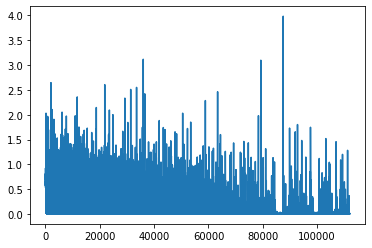

In [16]:
criterion_sub = nn.CrossEntropyLoss()
optimizer_sub = torch.optim.SGD(model_subjectivity.parameters(), lr=0.2)
loss_subj = train_model(model_subjectivity,70,criterion_sub,train_dataloader_sub,test_dataloader_sub,"new_model_subjectivity_data_trained_.pth",optimizer_sub)


In [17]:
evalu(test_dataloader_sub,test_dataset_sub,model_subjectivity)

count_pos :  62.0 count_neg :  39.0
correct:  1899
Accuracy of the network on the 2000 test data: 94 %
Accuracy of the network on the 2000 test data: 94 %
negative mis


# **Second Classification Phase**

In [18]:
def preprocess_data(corpus,model_encoding,classifier):
    model_encoding.to(device)
    classifier.to(device)
    #corpus = [lol2str(d) for d in neg] + [lol2str(d) for d in pos]
    # embeddings_corpus = model.encode(corpus,convert_to_numpy=False,convert_to_tensor=True)

    # #Store sentences & embeddings on disc
    # with open('embeddings_polarity_long_ALL.pkl', "wb") as fOut:
    #     pickle.dump({'sentences': corpus, 'embeddings_corpus': embeddings_corpus}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

    # #Load sentences & embeddings from disc
    # with open('embeddings_polarity_long_ALL.pkl', "rb") as fIn:
    #     stored_data = pickle.load(fIn)
    #     stored_sentences = stored_data['sentences']
    #     stored_embeddings = stored_data['embeddings_corpus']
    clean_data = []

    for review in tqdm(corpus):
        sentences = nltk.sent_tokenize(review)
        subjective_sentences = ""
        for sent in sentences:
            #print(sent)
            sent_enc = model_encoding.encode([sent],convert_to_numpy=False,convert_to_tensor=True)
            output = classifier(sent_enc)

            __, predict = torch.max(output.data,1)
            if(predict == 1):
                #print(sent)
                subjective_sentences = subjective_sentences+sent
            #subjective_sentences = subjective_sentences+sent
        clean_data.append(subjective_sentences)
        #print("clean data \n",clean_data[0])
    # with open('clean_DATA_prova.pkl', "wb") as fOut:
    #     pickle.dump({'review': clean_data}, fOut, protocol=pickle.HIGHEST_PROTOCOL)
    return clean_data

In [19]:
corpus_polarity_ = [lol2str(d) for d in neg] + [lol2str(d) for d in pos]

clean_data = preprocess_data(corpus_polarity_,model,model_subjectivity)
clean_data = remove_punkt(clean_data)
clean_data = [lol2str_(i) for i in clean_data]

100%|██████████| 2000/2000 [14:02<00:00,  2.38it/s]


In [20]:
clean_data_emb = embedd_review(clean_data,model)

100%|██████████| 2000/2000 [01:00<00:00, 33.16it/s]


In [26]:
clean_classifier = Net()
criterion_ = nn.CrossEntropyLoss()
for i in clean_data_emb:
  torch.Tensor(i)
optimizer_clean = torch.optim.SGD(clean_classifier.parameters(),lr=0.1)
labels_polarity_clean = numpy.array([0] * 1000 + [1] * 1000) 
#labels = torch.tensor(labels)
#stored_embeddings = torch.tensor(stored_embeddings)
#print(stored_embeddings[0])
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(clean_data_emb, labels_polarity_clean, test_size=0.33, random_state=42)
dataset_clean = pol_database(X_train_clean,y_train_clean)
test_dataset_clean = pol_database(X_test_clean,y_test_clean)
train_dataloader_clean = DataLoader(dataset_clean, shuffle=True, batch_size=5)
test_dataloader_clean = DataLoader(test_dataset_clean,shuffle=True, batch_size=5)

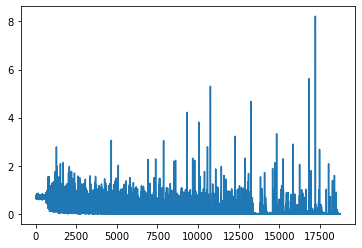

In [29]:
torch.set_grad_enabled(True)
loss_objec = train_model(clean_classifier,70,criterion_,train_dataloader_clean,test_dataloader_clean,"clean_classifier.pth",optimizer_clean)

In [39]:
evalu(test_dataloader_clean,test_dataset_clean,clean_classifier)

count_pos :  40.0 count_neg :  48.0
correct:  572
Accuracy of the network on the 660 test data: 86 %
Accuracy of the network on the 660 test data: 86 %
negative mis
